<a href="https://colab.research.google.com/github/junsookim76/ChemML/blob/main/rdkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -q
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local &>/dev/null
!conda install -q -y -c rdkit rdkit python=3.7
!pip install -q mordred seaborn
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
IPythonConsole.ipython_useSVG=True

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - python=3.7
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bottleneck-1.3.2           |   py37heb32a55_1         125 KB
    brotlipy-0.7.0             |py37h27cfd23_1003         320 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB
    cairo-1.16.0               |       hf32fb01_1         1.0 MB
    certifi-2021.10.8          |   py37h06a4308_0         151 KB
    cffi-1.14.6                |   py37h400218f_0         223 KB
    chardet-4.0.0              |py37h06a4308_1003         195 KB
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    conda-package-handling-1.7.3|   py37h27cfd23_1   

# Reading Database

In [2]:
!wget https://raw.githubusercontent.com/junsookim76/ChemML/main/chembl_mini.smi

--2021-11-22 08:01:50--  https://raw.githubusercontent.com/junsookim76/ChemML/main/chembl_mini.smi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249616 (244K) [text/plain]
Saving to: ‘chembl_mini.smi’

chembl_mini.smi     100%[===================>] 243.77K  --.-KB/s    in 0.02s   

2021-11-22 08:01:51 (10.8 MB/s) - ‘chembl_mini.smi’ saved [249616/249616]



In [13]:
mol=Chem.MolFromSmiles("c1cnccc1/C=C/C2CCCCC2-C#N")
mol

In [19]:
mols=[]
with open("./chembl_mini.smi") as f:
    for line in f.readlines():
        data=line.split()
        mol=Chem.MolFromSmiles(data[0])
        mol.SetProp("chembl_id",data[1])
        mol.SetProp("smiles",data[0])
        mols.append(mol)

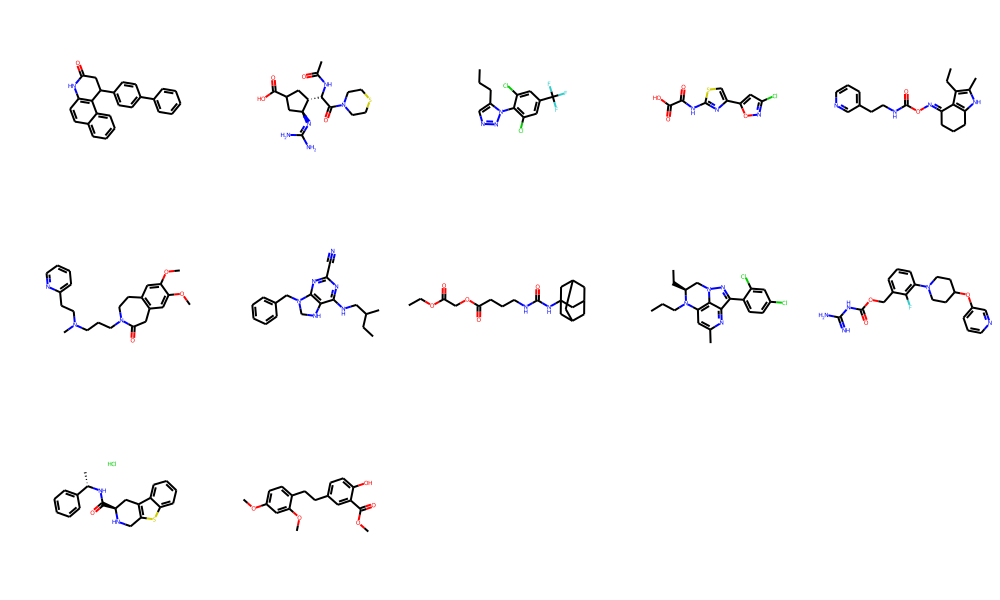

In [20]:
Draw.MolsToGridImage(mols[16:28],molsPerRow=5)

# Mordred Descriptors

In [24]:
n_all = len(Calculator(descriptors, ignore_3D=False).descriptors)
n_2D = len(Calculator(descriptors, ignore_3D=True).descriptors)
print("2D:    {:5}\n3D:    {:5}\n------------\ntotal: {:5}".format(n_2D, n_all - n_2D, n_all))

2D:     1613
3D:      213
------------
total:  1826


In [21]:
calc=Calculator(descriptors.ABCIndex)

In [22]:
calc.register(descriptors.AcidBase)
calc.register(descriptors.Aromatic)
#calc.register(descriptors.AtomCount)
calc.register(descriptors.BondCount)
calc.register(descriptors.BalabanJ)
calc.register(descriptors.HydrogenBond)
calc.register(descriptors.Polarizability)
calc.register(descriptors.WalkCount)
calc.register(descriptors.Weight)
calc.register(descriptors.TopologicalCharge)
mordred=calc.pandas(mols)

100%|██████████| 5000/5000 [01:00<00:00, 82.31it/s]


In [26]:
mordred

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nBonds,nBondsO,nBondsS,nBondsD,nBondsT,nBondsA,nBondsM,nBondsKS,nBondsKD,BalabanJ,nHBAcc,nHBDon,apol,bpol,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,GGI1,GGI2,GGI3,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,GGI10,JGI1,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10
0,12.377494,11.320978,0,3,10,10,30,17,19,1,0,10,11,25,5,1.803450,4,2,33.768309,18.351691,17.0,4.418841,5.241747,6.115892,6.965080,7.841886,8.702012,9.579349,10.445201,11.322479,103.632487,3.555348,0.0,4.875197,3.044522,6.343880,5.351858,7.882692,7.379632,9.464595,63.897726,235.089166,8.106523,4.5,1.777778,1.263889,0.820000,0.382222,0.329932,0.103316,0.161265,0.000000,0.000000,0.264706,0.074074,0.066520,0.048235,0.025481,0.032993,0.012915,0.026878,0.000000,0.000000,0.551803
1,15.901098,13.784340,0,0,12,12,37,22,24,1,0,12,13,30,7,1.945673,6,5,40.161895,16.784105,22.0,4.672829,5.517453,6.398595,7.257708,8.143517,9.008591,9.897017,10.765428,11.655856,116.316994,3.806662,0.0,5.129899,0.000000,6.655440,0.000000,8.278174,0.000000,9.951087,54.821262,289.095023,8.030417,5.0,2.888889,2.312500,1.497778,0.833333,0.405714,0.267361,0.233560,0.085625,0.070095,0.227273,0.093190,0.068015,0.048315,0.037879,0.018442,0.014853,0.016683,0.008563,0.017524,0.550736
2,12.934771,11.320765,1,0,9,10,29,18,17,2,0,10,12,23,6,1.875346,3,2,31.682723,15.077277,18.0,4.465908,5.303305,6.175867,7.043160,7.923348,8.801921,9.686015,10.569597,11.455794,106.424916,3.610918,0.0,4.919981,2.397895,6.418365,4.727388,8.004032,6.842683,9.637371,63.558633,233.068808,8.323886,4.0,2.222222,1.229167,1.018333,0.482778,0.359410,0.165816,0.080633,0.040000,0.000000,0.222222,0.088889,0.051215,0.050917,0.030174,0.027647,0.020727,0.011519,0.013333,0.000000,0.516643
3,7.956514,7.521784,0,0,6,6,17,11,10,1,0,6,7,13,4,2.267647,2,2,23.744758,9.997242,11.0,3.931826,4.709530,5.517453,6.318968,7.131699,7.938446,8.752265,9.560363,10.374335,86.234884,3.135494,0.0,4.369448,0.000000,5.814131,0.000000,7.341484,0.000000,8.906935,40.567492,262.944326,15.467313,2.5,1.555556,0.500000,0.382222,0.263889,0.080816,0.000000,0.000000,0.000000,0.000000,0.227273,0.111111,0.038462,0.047778,0.052778,0.026939,0.000000,0.000000,0.000000,0.000000,0.504340
4,19.099223,14.826865,0,0,6,6,53,27,45,2,0,6,8,48,5,1.394835,3,0,54.812618,30.423382,27.0,4.905275,5.783825,6.705639,7.604396,8.533657,9.440420,10.373772,11.285159,12.221557,127.853700,4.007333,0.0,5.370638,0.000000,6.963190,0.000000,8.672315,0.000000,10.441004,59.454480,326.188195,6.523764,7.0,2.444444,1.875000,1.506667,0.951389,0.307755,0.395833,0.232552,0.136875,0.061830,0.259259,0.061111,0.046875,0.045657,0.031713,0.011398,0.015224,0.011074,0.009777,0.006870,0.498958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,14.170645,11.348074,0,0,11,11,32,20,19,2,0,11,13,25,7,1.444603,4,1,34.913516,16.326484,20.0,4.553877,5.389072,6.240276,7.089243,7.944137,8.797397,9.653936,10.509196,11.366662,109.543796,3.713572,0.0,5.003946,2.397895,6.490724,4.442651,8.059908,6.293419,9.670357,64.072473,240.101111,8.003370,3.0,2.222222,0.527778,0.454444,0.479444,0.347710,0.084184,0.053934,0.060633,0.037749,0.150000,0.082305,0.021991,0.022722,0.029965,0.028976,0.007653,0.005393,0.008662,0.009437,0.367104
4996,16.484101,15.059143,0,0,11,11,45,22,34,0,0,11,11,40,5,2.203430,4,3,49.058239,27.243761,22.0,4.744932,5.587249,6.520621,7.393263,8.322880,9.207837,10.135591,11.026126,11.952979,117.891477,3.806662,0.0,5.220356,2.397895,6.792344,4.595120,8.440960,6.555357,10.136779,68.945474,305.156183,6.935368,8.0,3.555556,2.347222,1.690000,1.722222,0.505170,0.532242,0.000000,0.000000,0.000000,0.363636,0.101587,0.071128,0.049706,0.055556,0.016296,0.031308,0.000000,0.000000,0.000000,0.689217
4997,

In [27]:
mordred['MW']

0       235.089166
1       289.095023
2       233.068808
3       262.944326
4       326.188195
           ...    
4995    240.101111
4996    305.156183
4997    352.113316
4998    363.092914
4999    254.203451
Name: MW, Length: 5000, dtype: float64

# Analysis of Descriptors

(64, 64)


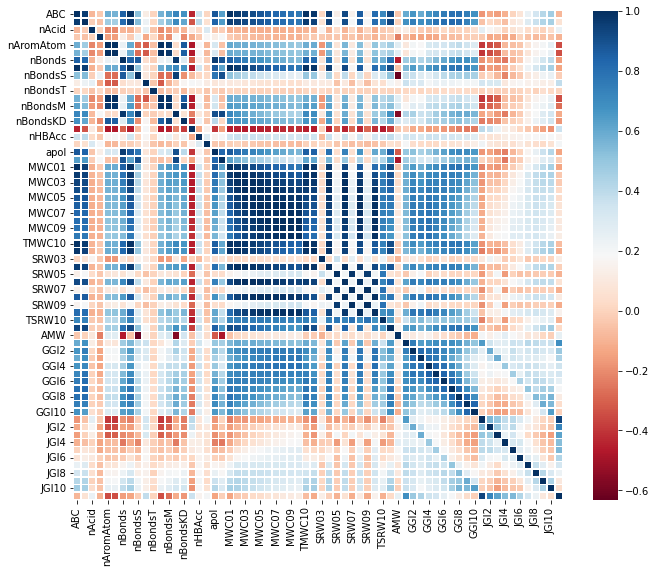

In [30]:
correlation=mordred.corr()
#mask=np.triu(np.ones_like(correlation, dtype=np.bool))
f,ax=plt.subplots(figsize=(11, 9))
sns.heatmap(
    correlation,
#    mask=mask,
    cmap="RdBu",
    square=True,
    linewidths=0.5,
)

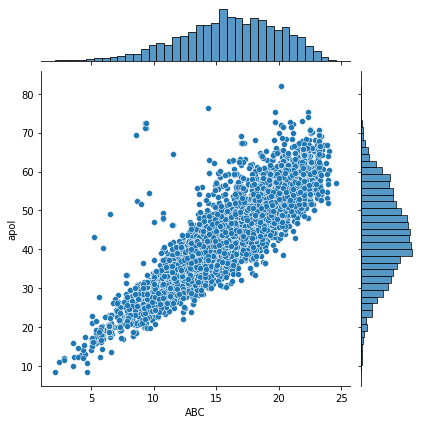

In [31]:
sns.jointplot(x='ABC',y='apol',data=mordred)

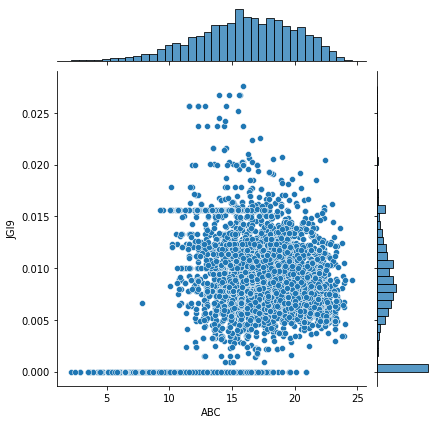

In [33]:
sns.jointplot(x='ABC',y='JGI9',data=mordred)

# Multi Linear Perceptron Regressor

In [35]:
MLP=make_pipeline(QuantileTransformer(),
                MLPRegressor(hidden_layer_sizes=(100, 50, 100),
                             learning_rate_init=0.01,
                             max_iter=500,
                             early_stopping=True))

In [36]:
X=mordred.drop(columns=['MW','AMW'])
y=mordred['MW']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7)

In [38]:
MLP.fit(X_train, y_train)

Pipeline(steps=[('quantiletransformer', QuantileTransformer()),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True,
                              hidden_layer_sizes=(100, 50, 100),
                              learning_rate_init=0.01, max_iter=500))])

(50.0, 450.0)

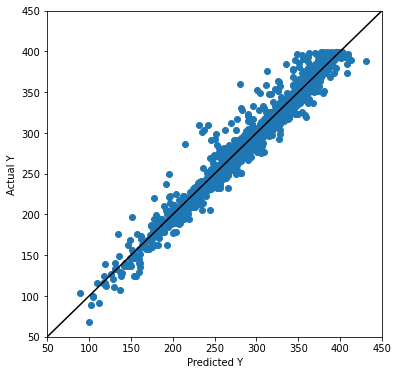

In [50]:
x = [-200, 50, 500]
y = [-200, 50, 500]

fig=plt.figure(figsize=(6,6))
plt.plot(MLP.predict(X_test),y_test,"o")
plt.plot(x,y, 'k-')
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")
plt.xlim(50,450)
plt.ylim(50,450)
#ax.set_aspect('equal', adjustable='box')


In [51]:
testsets='''Cc1cccc(/N=N/c2ccc(C(=O)O)cc2)c1	CHEMBL12916
CC1(C)Cc2cc(Cl)cc(Cl)c2C=[N+]1[O-]	CHEMBL12917
O=C(O)CCCCCC(=O)N1CCC2(CCN(c3ccncc3)CC2)C1	CHEMBL13002
CC(C)c1ccc2c(c1)CC[C@H]1[C@@H](CO)[C@@H](O)CC[C@]21C	CHEMBL12668
CC(C)c1ccccc1Sc1c(O)cc(-c2ccc([N+](=O)[O-])cc2)oc1=O	CHEMBL12671
CCCC/C=C(/c1ccc(O)cc1)c1ccc(OCCN(CC)CC)cc1	CHEMBL12959
CC(C)(C)c1ccc(C2OC2c2ccc(C(=O)O)cc2)cc1	CHEMBL12961
O=[N+]([O-])c1ccc(S(=O)(=O)CS(=O)(=O)C(F)(F)F)cc1	CHEMBL12894
CC(C)N(CCC(CCN1CCCCCC1)(C(N)=O)c1ccccc1)C(C)C	CHEMBL12982
Cn1cc(C(=O)c2ccccc2)cc1C=C(C(=O)NO)C(=O)NO	CHEMBL12983
COC(=O)c1ccccc1OCC(O)CNC(C)(C)CNC(N)=O	CHEMBL12984
Cn1cc(C(=O)c2ccccc2)cc1CC(=O)NO	CHEMBL12986
CN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3N(C)C)CC1	CHEMBL13004
CC1CCC(NC(=O)N(CCF)N=O)CC1	CHEMBL13005
CNn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCOCC3)cc21	CHEMBL13006
CC(C)(C)c1cc(/C=C/c2nnc(O)o2)cc(C(C)(C)C)c1O	CHEMBL12395
c1ccc2c3c([nH]c2c1)CN(CCc1cnccn1)CC3	CHEMBL12396
'''

In [60]:
testmols=[]
for i in testsets.split():
    if "CHEMBL" not in i:
        mol=Chem.MolFromSmiles(i)
        if mol is not None:
            testmols.append(mol)

In [61]:
testmol_param=calc.pandas(testmols)

100%|██████████| 17/17 [00:00<00:00, 72.49it/s]


In [62]:
testX=testmol_param.drop(columns=['MW','AMW'])

(50.0, 450.0)

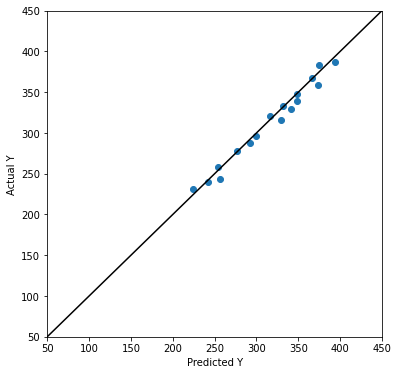

In [65]:
x = [-200, 50, 500]
y = [-200, 50, 500]

fig=plt.figure(figsize=(6,6))
plt.plot(MLP.predict(testX),testmol_param['MW'],"o")
plt.plot(x,y, 'k-')
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")
plt.xlim(50,450)
plt.ylim(50,450)


